In [19]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

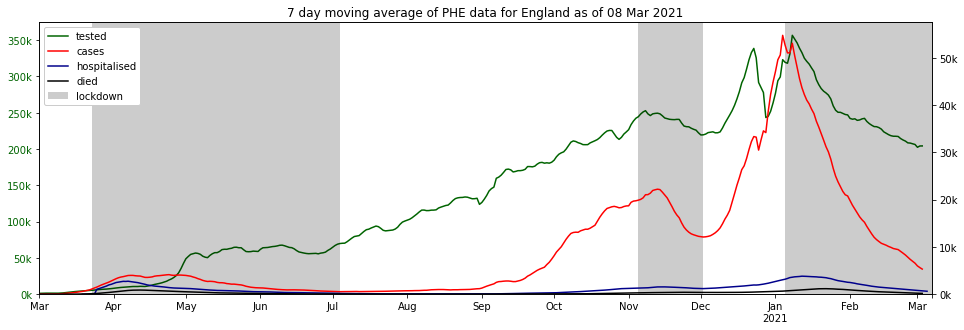

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum,),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

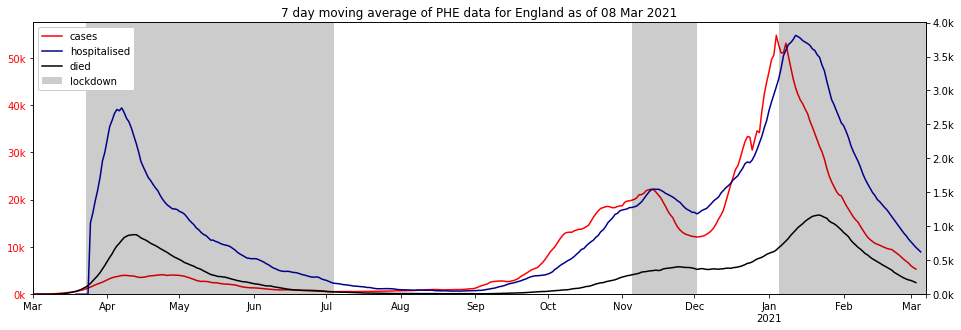

In [3]:
plot_summary(left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,797321.0,19015497.0,18218176.0,56286961,1.416529,32.366601,66.216870
1,Northern Ireland,N92000002,42851.0,588803.0,545952.0,1893667,2.262858,28.830412,68.906730
2,Scotland,S92000003,118732.0,1774659.0,1655927.0,5463300,2.173265,30.310014,67.516721
3,Wales,W92000004,183739.0,998296.0,814557.0,3152879,5.827658,25.835340,68.337002


'partial: 22,377,255 (33.5%), full: 1,142,643'

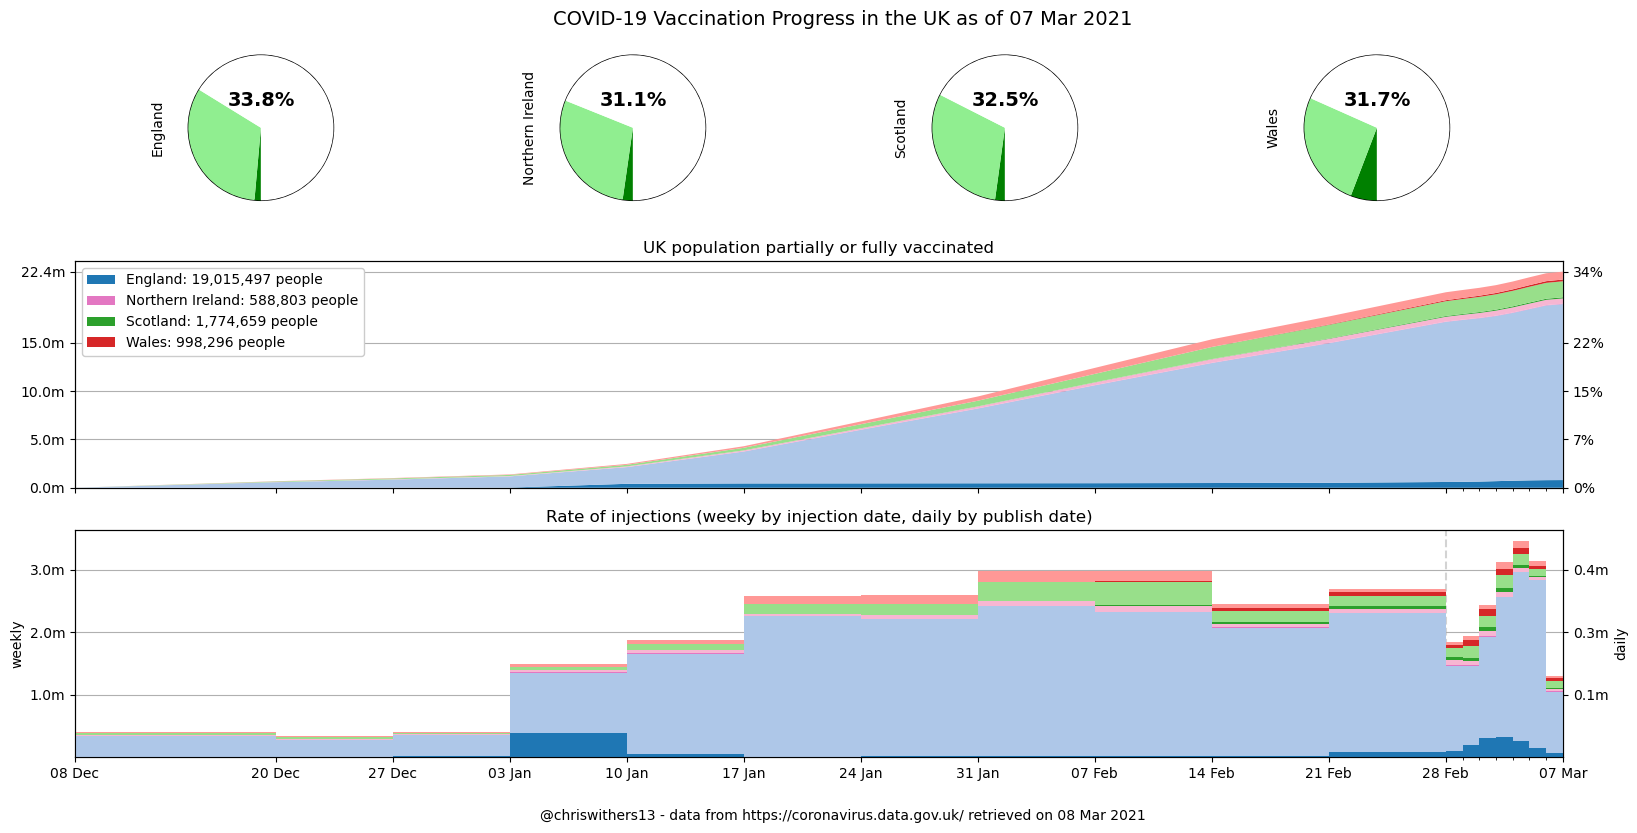

In [4]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [5]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,07 Mar 21,"+140,108","+9,133","+9,133","+19,015,497","+797,321","+797,321"
Northern Ireland,07 Mar 21,"+5,889",+621,+621,"+588,803","+42,851","+42,851"
Scotland,07 Mar 21,"+14,909","+2,802","+2,802","+1,774,659","+118,732","+118,732"
Wales,07 Mar 21,"+3,237","+7,685","+7,685","+998,296","+183,739","+183,739"


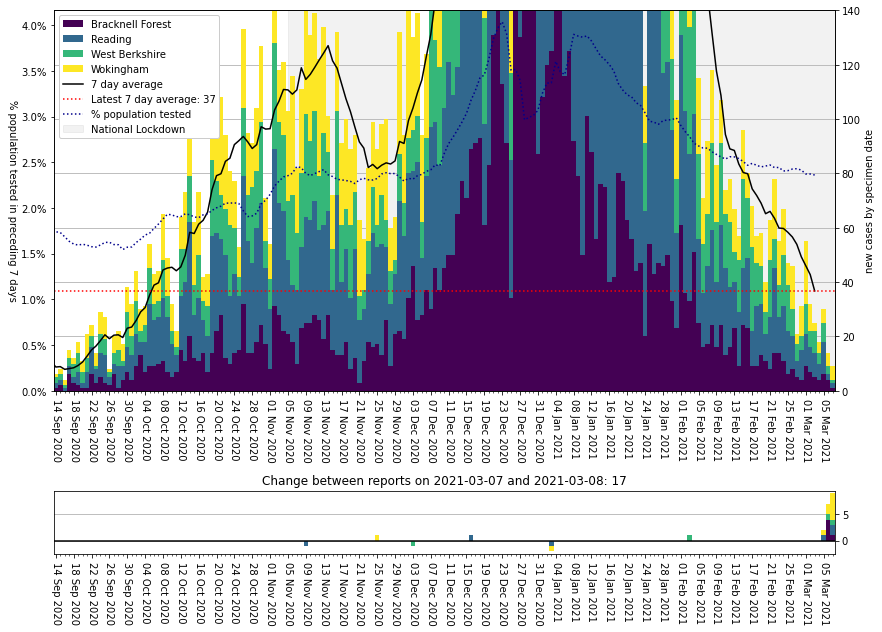

In [6]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=140)

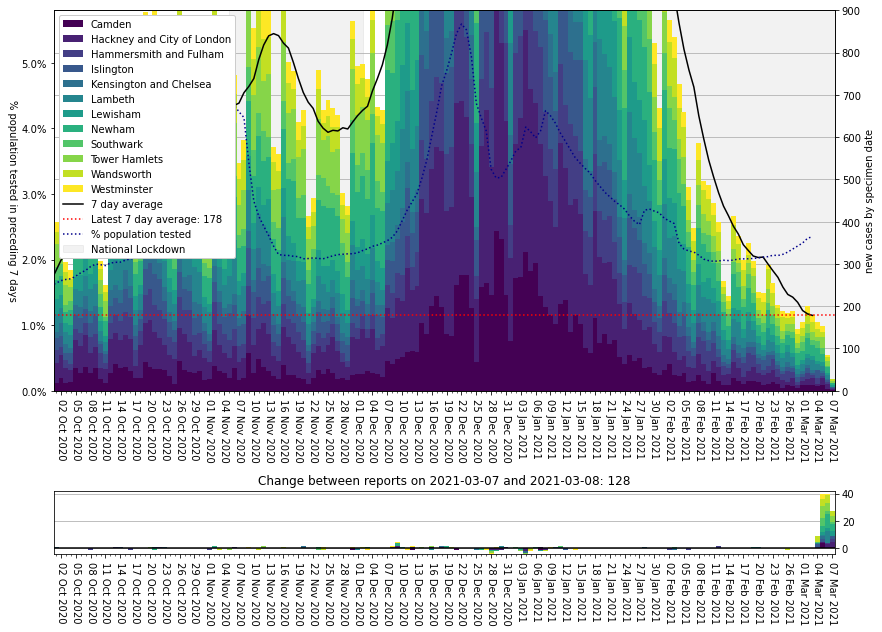

In [7]:
plot_areas(for_date, areas=london_areas, ylim=900)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [9]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000005,Clackmannanshire,151.338766,78.0,2021-03-07
E08000018,Rotherham,136.015463,361.0,2021-03-07
E06000010,"Kingston upon Hull, City of",132.805703,345.0,2021-03-07
E07000236,Redditch,130.188480,111.0,2021-03-07
E08000032,Bradford,129.683424,700.0,2021-03-07
E07000035,Derbyshire Dales,128.586243,93.0,2021-03-07
E08000016,Barnsley,128.004666,316.0,2021-03-07
E07000150,Corby,126.007367,91.0,2021-03-07
E07000123,Preston,124.358123,178.0,2021-03-07


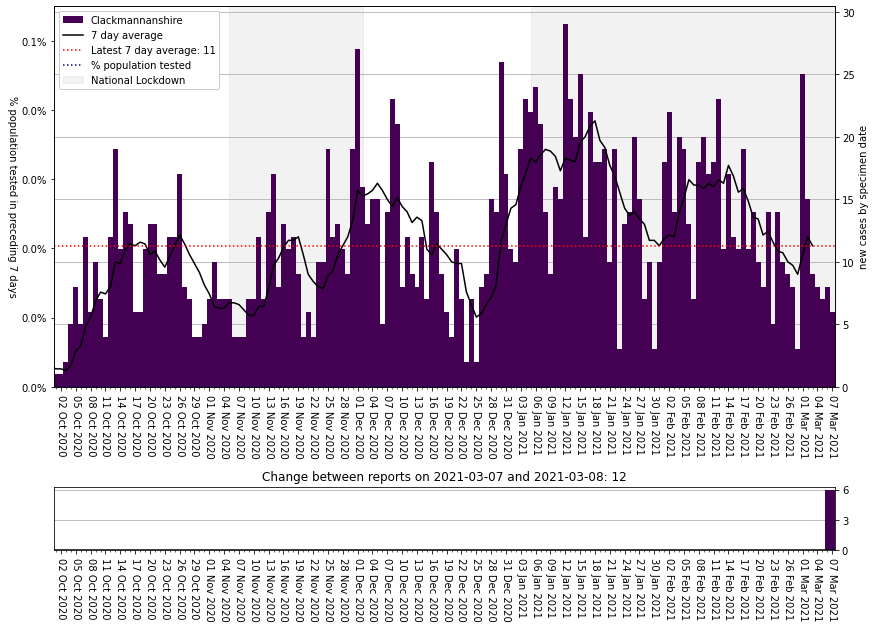

In [10]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [11]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,78.121168,892.0,2021-03-07
E08000032,Bradford,129.683424,700.0,2021-03-07
E08000035,Leeds,87.122182,691.0,2021-03-07
S12000049,Glasgow City,101.876422,645.0,2021-03-07
E08000019,Sheffield,71.128985,416.0,2021-03-07
E06000016,Leicester,117.157505,415.0,2021-03-07
E08000036,Wakefield,116.562163,406.0,2021-03-07
E08000034,Kirklees,91.407886,402.0,2021-03-07
E08000018,Rotherham,136.015463,361.0,2021-03-07


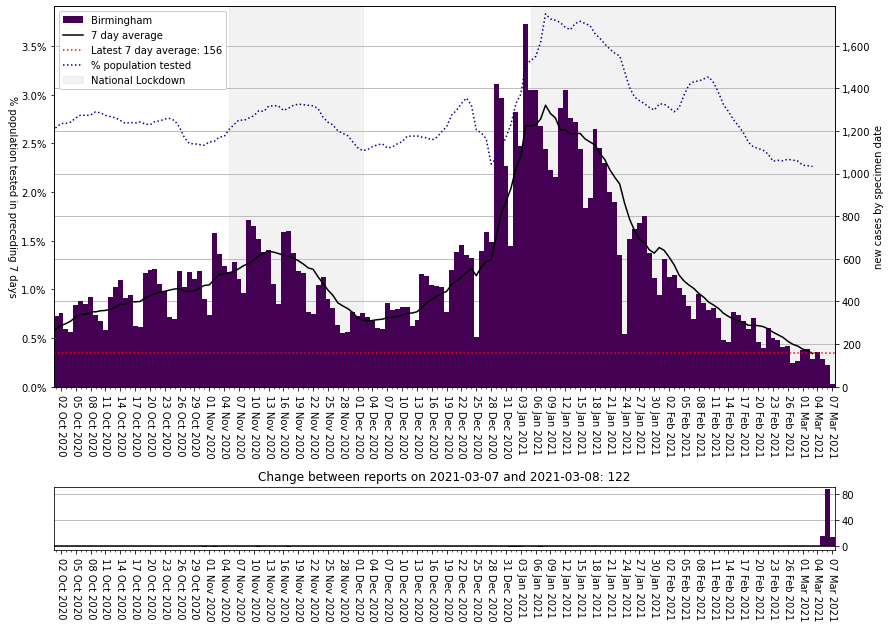

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 2.8
phe_max = 0.25

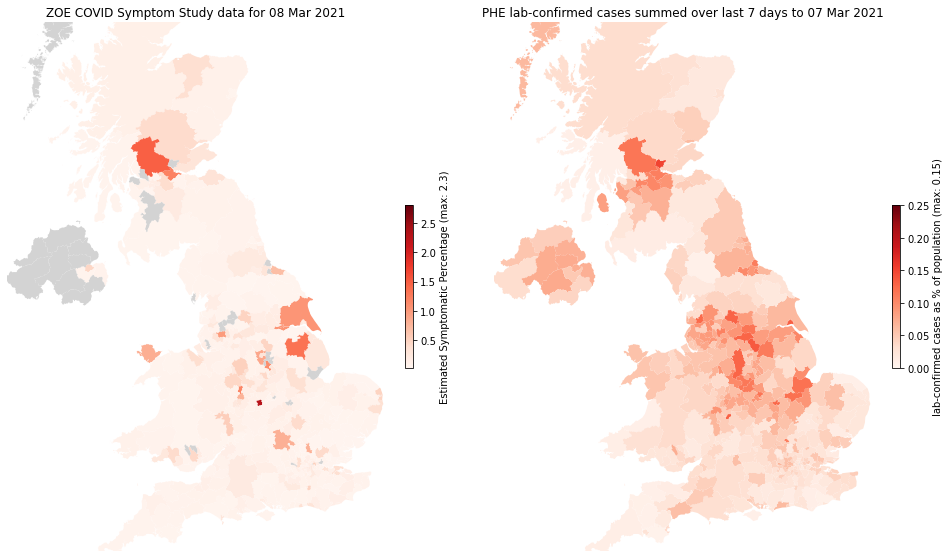

In [14]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [15]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

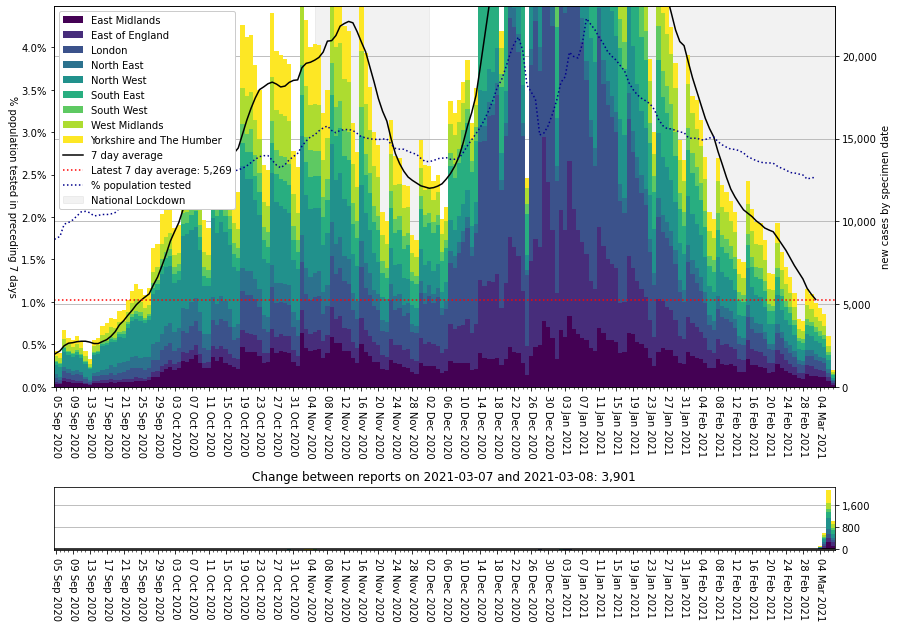

In [16]:
plot_areas(for_date, area_type=region, ylim=23_000, earliest='2020-09-05')

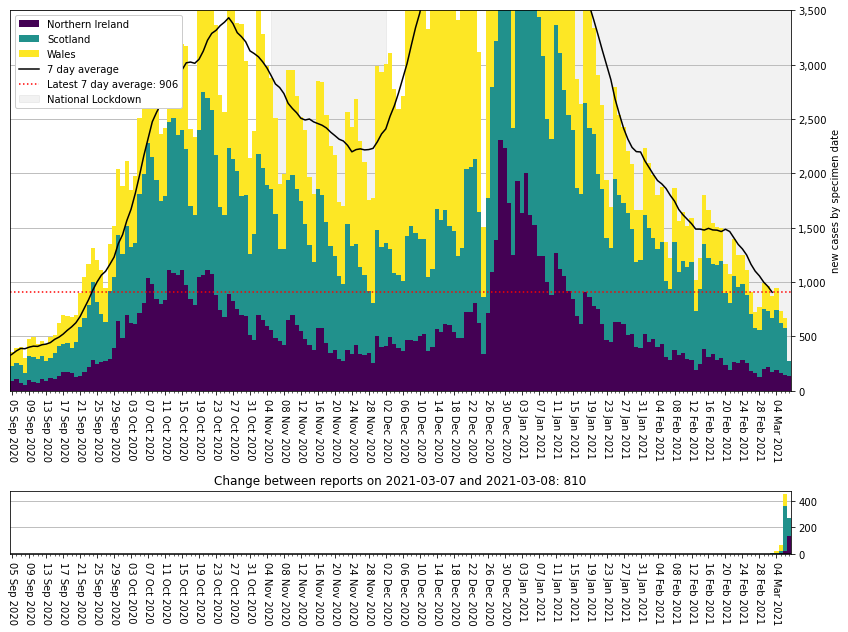

In [17]:
plot_areas(for_date, 'cases_devolved', ylim=3_500, diff_ylims=None, earliest='2020-09-05')